# Применение методов машинного обучения к задачам обнаружения вредоносных интернет-ресурсов

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.parse import urlparse, unquote
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

# Создание датасета

<h2>Предварительная обработка датасета полученного от Urlhause</h2>

In [ ]:
UrlHauseData = pd.read_csv('/tmp/Urlhause.csv')
UrlHauseData.head()

,Unnamed: 0,dateadded,url,url_status,last_online,threat,tags,urlhaus_link,reporter
0,0,2024-11-29 11:59:06 UTC,http://117.202.88.6:56947/bin.sh,online,2024-11-29 11:59:06 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3311616/,geenensp
1,1,2024-11-29 11:57:05 UTC,http://42.235.20.213:41718/i,online,2024-11-29 11:57:05 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3311615/,geenensp
2,2,2024-11-29 11:50:13 UTC,http://218.94.154.190:54555/Mozi.a,online,2024-11-29 11:50:13 UTC,malware_download,"['elf', 'Mozi']",https://urlhaus.abuse.ch/url/3311614/,lrz_urlhaus
3,3,2024-11-29 11:50:10 UTC,http://223.112.39.21:44070/Mozi.m,online,2024-11-29 11:50:10 UTC,malware_download,"['elf', 'Mozi']",https://urlhaus.abuse.ch/url/3311613/,lrz_urlhaus
4,4,2024-11-29 11:49:09 UTC,http://117.209.92.120:35822/Mozi.m,online,2024-11-29 11:49:09 UTC,malware_download,"['elf', 'Mozi']",https://urlhaus.abuse.ch/url/3311612/,lrz_urlhaus


In [ ]:
UrlHauseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174065 entries, 0 to 174064
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    174065 non-null  int64 
 1   dateadded     174065 non-null  object
 2   url           174065 non-null  object
 3   url_status    174065 non-null  object
 4   last_online   156843 non-null  object
 5   threat        174065 non-null  object
 6   tags          169667 non-null  object
 7   urlhaus_link  174065 non-null  object
 8   reporter      174065 non-null  object
dtypes: int64(1), object(8)
memory usage: 12.0+ MB


*Удаление ненужных столбцов*

In [ ]:
UrlHauseData = UrlHauseData.drop(['Unnamed: 0', 'dateadded', 'url_status', 'last_online', 'tags', 'urlhaus_link', 'reporter'], axis=1)
UrlHauseData.head()

,url,threat
0,http://117.202.88.6:56947/bin.sh,malware_download
1,http://42.235.20.213:41718/i,malware_download
2,http://218.94.154.190:54555/Mozi.a,malware_download
3,http://223.112.39.21:44070/Mozi.m,malware_download
4,http://117.209.92.120:35822/Mozi.m,malware_download


*Переименуем столбец threat в type*

In [ ]:
UrlHauseData = UrlHauseData.rename(columns={'threat': 'type'})
UrlHauseData.head()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware_download
1,http://42.235.20.213:41718/i,malware_download
2,http://218.94.154.190:54555/Mozi.a,malware_download
3,http://223.112.39.21:44070/Mozi.m,malware_download
4,http://117.209.92.120:35822/Mozi.m,malware_download


In [ ]:
UrlHauseData['type'].value_counts()

,count
type,
malware_download,174065


*Значение malware_download говорит о принадлежности данного URL к классу malware, поэтому заменим эти значения на обобщенный вариант malware*

In [ ]:
UrlHauseData['type'] = UrlHauseData['type'].replace('malware_download', 'malware')
UrlHauseData['type'].value_counts()

,count
type,
malware,174065


In [ ]:
UrlHauseData.head()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware
1,http://42.235.20.213:41718/i,malware
2,http://218.94.154.190:54555/Mozi.a,malware
3,http://223.112.39.21:44070/Mozi.m,malware
4,http://117.209.92.120:35822/Mozi.m,malware


<h2>Предварительная обработка датасета полученного от PhishTank</h2>

In [ ]:
PhishTankData = pd.read_csv('/tmp/PhishTank.csv')
PhishTankData.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,8875685,https://vcxemtmuff.cfolks.pl/aa/a/web/login.php,http://www.phishtank.com/phish_detail.php?phis...,2024-11-28T18:10:56+00:00,yes,2024-11-28T18:12:32+00:00,yes,Other
1,8875665,https://allegrolokalnle.1903453.xyz/robot-check,http://www.phishtank.com/phish_detail.php?phis...,2024-11-28T17:55:10+00:00,yes,2024-11-28T18:03:04+00:00,yes,Other
2,8875663,https://docs.google.com/presentation/d/e/2PACX...,http://www.phishtank.com/phish_detail.php?phis...,2024-11-28T17:50:59+00:00,yes,2024-11-28T18:03:04+00:00,yes,Other
3,8875613,https://docs.google.com/presentation/d/e/2PACX...,http://www.phishtank.com/phish_detail.php?phis...,2024-11-28T17:31:39+00:00,yes,2024-11-28T17:41:59+00:00,yes,Other
4,8875611,https://allegrolokalnie.90283976.online/oferta...,http://www.phishtank.com/phish_detail.php?phis...,2024-11-28T17:30:45+00:00,yes,2024-11-28T17:41:59+00:00,yes,Allegro


In [ ]:
PhishTankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68378 entries, 0 to 68377
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   phish_id           68378 non-null  int64 
 1   url                68378 non-null  object
 2   phish_detail_url   68378 non-null  object
 3   submission_time    68378 non-null  object
 4   verified           68378 non-null  object
 5   verification_time  68378 non-null  object
 6   online             68378 non-null  object
 7   target             68378 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.2+ MB


*Удаление ненужных столбцов*

In [ ]:
PhishTankData = PhishTankData.drop(['phish_id', 'phish_detail_url', 'submission_time', 'verification_time', 'online', 'target'], axis=1)
PhishTankData.head()

,url,verified
0,https://vcxemtmuff.cfolks.pl/aa/a/web/login.php,yes
1,https://allegrolokalnle.1903453.xyz/robot-check,yes
2,https://docs.google.com/presentation/d/e/2PACX...,yes
3,https://docs.google.com/presentation/d/e/2PACX...,yes
4,https://allegrolokalnie.90283976.online/oferta...,yes


*Переименуем столбец verified в type*

In [ ]:
PhishTankData = PhishTankData.rename(columns={'verified': 'type'})
PhishTankData.head()

,url,type
0,https://vcxemtmuff.cfolks.pl/aa/a/web/login.php,yes
1,https://allegrolokalnle.1903453.xyz/robot-check,yes
2,https://docs.google.com/presentation/d/e/2PACX...,yes
3,https://docs.google.com/presentation/d/e/2PACX...,yes
4,https://allegrolokalnie.90283976.online/oferta...,yes


In [ ]:
PhishTankData['type'].value_counts()

,count
type,
yes,68378


*Значение yes говорит о принадлежности данного URL к классу phishing, поэтому заменим эти значения на обобщенный вариант phishing*

In [ ]:
PhishTankData['type'] = PhishTankData['type'].replace('yes', 'phishing')
PhishTankData['type'].value_counts()

,count
type,
phishing,68378


In [ ]:
PhishTankData.head()

,url,type
0,https://vcxemtmuff.cfolks.pl/aa/a/web/login.php,phishing
1,https://allegrolokalnle.1903453.xyz/robot-check,phishing
2,https://docs.google.com/presentation/d/e/2PACX...,phishing
3,https://docs.google.com/presentation/d/e/2PACX...,phishing
4,https://allegrolokalnie.90283976.online/oferta...,phishing


<h2>Предварительная обработка датасета полученного от UCI Machine Learning Repository</h2>

In [ ]:
UCIData = pd.read_csv('/tmp/UCI Machine Learning Repository.csv')
UCIData.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
UCIData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

*Удаление ненужных столбцов*

In [ ]:
UCIData = UCIData[['URL', 'label']]
UCIData.head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


*Переименуем столбец label в type, а столбец URL в url*

In [ ]:
UCIData = UCIData.rename(columns={'label': 'type', 'URL': 'url'})
UCIData.head()

,url,type
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [ ]:
UCIData['type'].value_counts()

,count
type,
1,134850
0,100945


*Значение 1 говорит о принадлежности данного URL к классу legitimate , тогда как значение 0 - к классу phishing, поэтому заменим эти значения следующим образом: 0 = phishing, 1 = legitimate*

In [ ]:
UCIData['type'] = UCIData['type'].replace(0, 'phishing')
UCIData['type'] = UCIData['type'].replace(1, 'legitimate')
UCIData['type'].value_counts()

,count
type,
legitimate,134850
phishing,100945


In [ ]:
UCIData.head()

,url,type
0,https://www.southbankmosaics.com,legitimate
1,https://www.uni-mainz.de,legitimate
2,https://www.voicefmradio.co.uk,legitimate
3,https://www.sfnmjournal.com,legitimate
4,https://www.rewildingargentina.org,legitimate


<h2>Предварительная обработка датасета полученного от ThreatFox</h2>

In [ ]:
ThreatFoxData = pd.read_csv('/tmp/ThreatFox.csv')
ThreatFoxData.head()

,Unnamed: 0,ioc_value,ioc_type,threat_type,malware,malware_alias,malware_printable,first_seen_utc,last_seen_utc,confidence_level,reference,tags,anonymous,reporter
0,0,http://94.156.177.41/davinci/five/PvqDq929BSx_...,url,botnet_cc,apk.lokibot,NaN,LokiBot,2024-11-29 09:01:34,NaN,100,NaN,"AS214943,lokibot,Railnet LLC",0,antiphishorg
1,1,https://kotov.lol/,url,botnet_cc,win.vidar,NaN,Vidar,2024-11-29 08:48:39,NaN,100,NaN,Vidar,0,crep1x
2,2,https://195.201.44.101/,url,botnet_cc,win.vidar,NaN,Vidar,2024-11-29 08:48:38,NaN,100,NaN,Vidar,0,crep1x
3,3,https://powermasteryonline.com/xmlrpc.php,url,botnet_cc,js.gootloader,SLOWPOUR,GootLoader,2024-11-29 08:42:14,NaN,75,NaN,NaN,0,lontze7
4,4,https://encryption-code-verification.b-cdn.net...,url,payload_delivery,win.lumma,LummaC2 Stealer,Lumma Stealer,2024-11-29 08:42:14,NaN,100,NaN,NaN,0,lontze7


In [ ]:
ThreatFoxData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264829 entries, 0 to 264828
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         264829 non-null  int64 
 1   ioc_value          264829 non-null  object
 2   ioc_type           264829 non-null  object
 3   threat_type        264829 non-null  object
 4   malware            264829 non-null  object
 5   malware_alias      240164 non-null  object
 6   malware_printable  264829 non-null  object
 7   first_seen_utc     264829 non-null  object
 8   last_seen_utc      99897 non-null   object
 9   confidence_level   264829 non-null  int64 
 10  reference          13744 non-null   object
 11  tags               257358 non-null  object
 12  anonymous          264829 non-null  int64 
 13  reporter           264829 non-null  object
dtypes: int64(3), object(11)
memory usage: 28.3+ MB


*Удаление ненужных столбцов*

In [ ]:
ThreatFoxData = ThreatFoxData[['ioc_value', 'threat_type']]
ThreatFoxData.head()

,ioc_value,threat_type
0,http://94.156.177.41/davinci/five/PvqDq929BSx_...,botnet_cc
1,https://kotov.lol/,botnet_cc
2,https://195.201.44.101/,botnet_cc
3,https://powermasteryonline.com/xmlrpc.php,botnet_cc
4,https://encryption-code-verification.b-cdn.net...,payload_delivery


*Переименуем столбец threat_type в type, а столбец ioc_value в url*

In [ ]:
ThreatFoxData = ThreatFoxData.rename(columns={'threat_type': 'type', 'ioc_value': 'url'})
ThreatFoxData.head()

,url,type
0,http://94.156.177.41/davinci/five/PvqDq929BSx_...,botnet_cc
1,https://kotov.lol/,botnet_cc
2,https://195.201.44.101/,botnet_cc
3,https://powermasteryonline.com/xmlrpc.php,botnet_cc
4,https://encryption-code-verification.b-cdn.net...,payload_delivery


In [ ]:
ThreatFoxData['type'].value_counts()

,count
type,
payload_delivery,180292
botnet_cc,84537


*Значения payload_delivery и botnet_cc говорят о принадлежности данного URL к классу malware, поэтому заменим эти значения на обобщенный вариант malware*

In [ ]:
ThreatFoxData['type'] = ThreatFoxData['type'].replace('payload_delivery', 'malware')
ThreatFoxData['type'] = ThreatFoxData['type'].replace('botnet_cc', 'malware')
ThreatFoxData['type'].value_counts()

,count
type,
malware,264829


In [ ]:
ThreatFoxData.head()

,url,type
0,http://94.156.177.41/davinci/five/PvqDq929BSx_...,malware
1,https://kotov.lol/,malware
2,https://195.201.44.101/,malware
3,https://powermasteryonline.com/xmlrpc.php,malware
4,https://encryption-code-verification.b-cdn.net...,malware


<h2>Объединение полученных датасетов</h2>

In [ ]:
data = pd.concat([UrlHauseData, PhishTankData, UCIData, ThreatFoxData], ignore_index=True)
data.head()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware
1,http://42.235.20.213:41718/i,malware
2,http://218.94.154.190:54555/Mozi.a,malware
3,http://223.112.39.21:44070/Mozi.m,malware
4,http://117.209.92.120:35822/Mozi.m,malware


<a id="3"></a> <br>
# Информация об итоговом датасете

In [ ]:
data.head()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware
1,http://42.235.20.213:41718/i,malware
2,http://218.94.154.190:54555/Mozi.a,malware
3,http://223.112.39.21:44070/Mozi.m,malware
4,http://117.209.92.120:35822/Mozi.m,malware


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743067 entries, 0 to 743066
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     743067 non-null  object
 1   type    743067 non-null  object
dtypes: object(2)
memory usage: 11.3+ MB


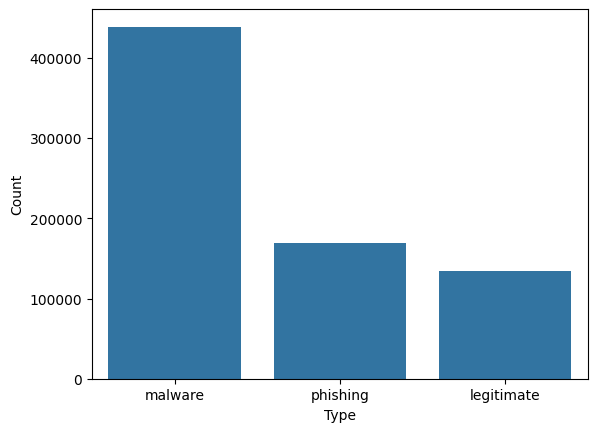

In [ ]:
count = data.type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Type')
plt.ylabel('Count');

<a id="4"></a>
# Предварительная обработка датасета

*Удаление "NaN" значений*

In [ ]:
data.dropna()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware
1,http://42.235.20.213:41718/i,malware
2,http://218.94.154.190:54555/Mozi.a,malware
3,http://223.112.39.21:44070/Mozi.m,malware
4,http://117.209.92.120:35822/Mozi.m,malware
...,...,...
743062,http://leffersinda.ru/8/forum.php,malware
743063,http://nuatanste.com/8/forum.php,malware
743064,http://thircussovirom.ru/8/forum.php,malware
743065,http://188.127.224.100/up.msi,malware


In [ ]:
data.isnull().sum()

,0
url,0
type,0


*Удаление дубликатов*

In [ ]:
data = data.drop_duplicates(subset='url', keep='first', ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738803 entries, 0 to 738802
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     738803 non-null  object
 1   type    738803 non-null  object
dtypes: object(2)
memory usage: 11.3+ MB


*Избавимся от "www."*

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)

In [ ]:
data.head()

,url,type
0,http://117.202.88.6:56947/bin.sh,malware
1,http://42.235.20.213:41718/i,malware
2,http://218.94.154.190:54555/Mozi.a,malware
3,http://223.112.39.21:44070/Mozi.m,malware
4,http://117.209.92.120:35822/Mozi.m,malware


*Добавим численное представление legitimate, phishing, malware в столбец class*

In [ ]:
rem = {"class": {"legitimate": 0, "phishing":1, "malware":2}}
data['class'] = data['type']
data = data.replace(rem)

<ipython-input-123-4c5f6e59c484>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


In [ ]:
data['class'].value_counts()

,count
class,
2,437794
1,166159
0,134850


<a id="5"></a> <br>
# Подготовка данных

*Добавление столбца, содержащего длину URL*

In [ ]:
data['length'] = data['url'].apply(lambda x: len(str(x)))

In [ ]:
data.head()

,url,type,class,length
0,http://117.202.88.6:56947/bin.sh,malware,2,32
1,http://42.235.20.213:41718/i,malware,2,28
2,http://218.94.154.190:54555/Mozi.a,malware,2,34
3,http://223.112.39.21:44070/Mozi.m,malware,2,33
4,http://117.209.92.120:35822/Mozi.m,malware,2,34


*Добавление столбца, содержащего длину домена URL*

In [ ]:
data['domainLength'] = data['url'].apply(lambda i: len(urlparse(i).netloc))

In [ ]:
data.head()

,url,type,class,length,domainLength
0,http://117.202.88.6:56947/bin.sh,malware,2,32,18
1,http://42.235.20.213:41718/i,malware,2,28,19
2,http://218.94.154.190:54555/Mozi.a,malware,2,34,20
3,http://223.112.39.21:44070/Mozi.m,malware,2,33,19
4,http://117.209.92.120:35822/Mozi.m,malware,2,34,20


*Добавление столбцов, содержащих количество специальных символов в URL*



In [ ]:
feature = ['@','?','-','=','.','#','+','$','!','*',',']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,","
0,http://117.202.88.6:56947/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0
1,http://42.235.20.213:41718/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0
2,http://218.94.154.190:54555/Mozi.a,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0
3,http://223.112.39.21:44070/Mozi.m,malware,2,33,19,0,0,0,0,4,0,0,0,0,0,0
4,http://117.209.92.120:35822/Mozi.m,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0


*Добавление столбца, содержащего наличие закодированных символов в URL*

In [ ]:
def encodedSymbolsCheck(url):
    decodedUrl = unquote(url)
    if url != decodedUrl:
        return 1
    else:
        return 0

In [ ]:
data['isEncodedSymbols'] = data['url'].apply(lambda i: encodedSymbolsCheck(i))

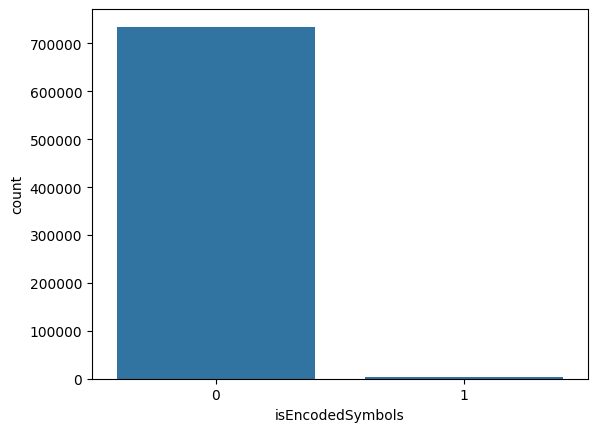

In [ ]:
sns.countplot(x='isEncodedSymbols', data=data);

*Добавление столбца, содержащего наличие https протокола в URL*

In [ ]:
def httpsCheck(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [ ]:
data['isHttps'] = data['url'].apply(lambda i: httpsCheck(i))

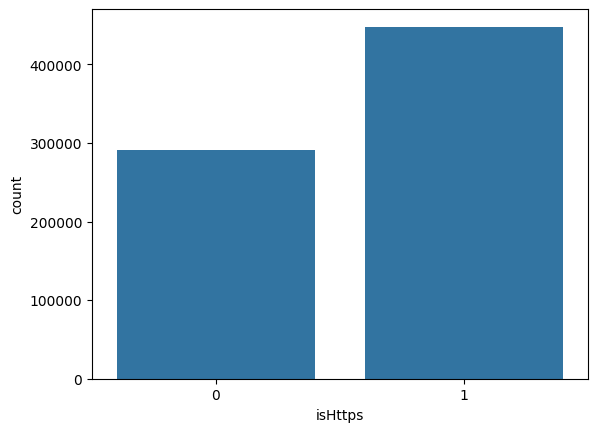

In [ ]:
sns.countplot(x='isHttps', data=data);

*Добавление столбца, содержащего количестов цифр в URL*

In [ ]:
def digitsCounter(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digitsCount']= data['url'].apply(lambda i: digitsCounter(i))

In [ ]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,",",isEncodedSymbols,isHttps,digitsCount
0,http://117.202.88.6:56947/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0,0,0,14
1,http://42.235.20.213:41718/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0,0,0,15
2,http://218.94.154.190:54555/Mozi.a,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16
3,http://223.112.39.21:44070/Mozi.m,malware,2,33,19,0,0,0,0,4,0,0,0,0,0,0,0,0,15
4,http://117.209.92.120:35822/Mozi.m,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16


*Добавление столбца, содержащего количестов букв в URL*

In [ ]:
def lettersCounter(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['lettersCount']= data['url'].apply(lambda i: lettersCounter(i))

In [ ]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,",",isEncodedSymbols,isHttps,digitsCount,lettersCount
0,http://117.202.88.6:56947/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0,0,0,14,9
1,http://42.235.20.213:41718/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0,0,0,15,5
2,http://218.94.154.190:54555/Mozi.a,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16,9
3,http://223.112.39.21:44070/Mozi.m,malware,2,33,19,0,0,0,0,4,0,0,0,0,0,0,0,0,15,9
4,http://117.209.92.120:35822/Mozi.m,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16,9


*Добавление столбца, содержащего информацию об применении сервисов для сокращения URL над исходным URL*

In [ ]:
def shortiningServiceCheck(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['isShortiningService'] = data['url'].apply(lambda x: shortiningServiceCheck(x))

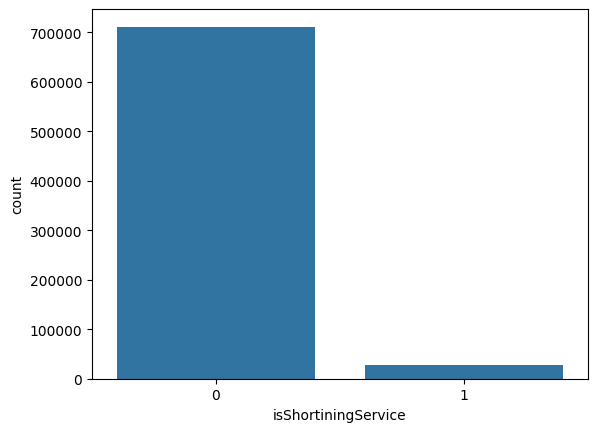

In [ ]:
sns.countplot(x='isShortiningService', data=data);

*Добавление столбца, содержащего наличие IP адреса в URL*

In [ ]:
def ipCheck(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['isIp'] = data['url'].apply(lambda i: ipCheck(i))

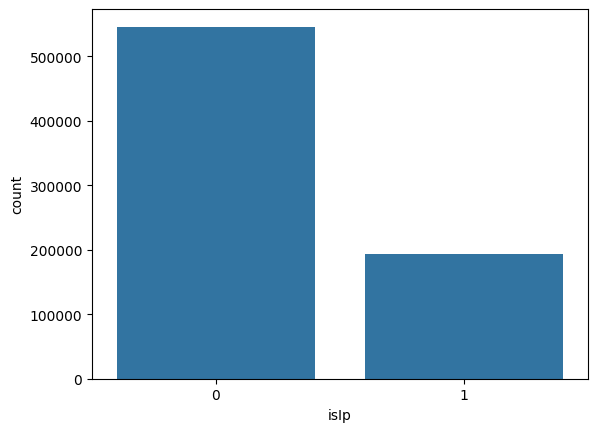

In [ ]:
sns.countplot(x='isIp', data=data);

# Информация об конечном датасете

<Axes: >

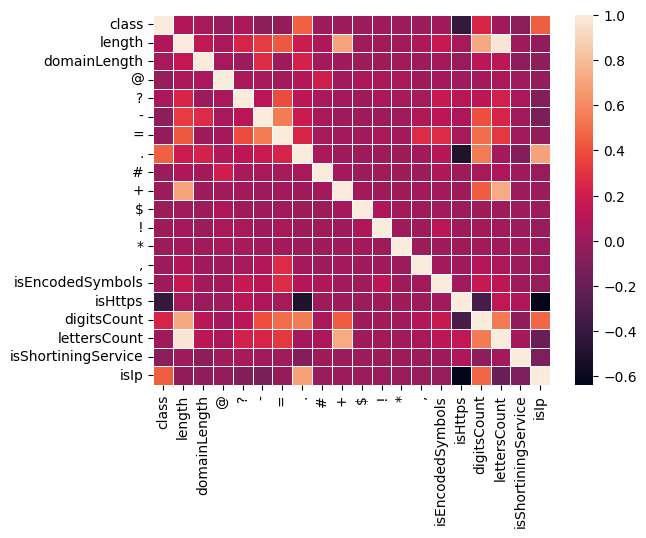

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), linewidths=.5)

In [ ]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,...,$,!,*,",",isEncodedSymbols,isHttps,digitsCount,lettersCount,isShortiningService,isIp
0,http://117.202.88.6:56947/bin.sh,malware,2,32,18,0,0,0,0,4,...,0,0,0,0,0,0,14,9,0,1
1,http://42.235.20.213:41718/i,malware,2,28,19,0,0,0,0,3,...,0,0,0,0,0,0,15,5,0,1
2,http://218.94.154.190:54555/Mozi.a,malware,2,34,20,0,0,0,0,4,...,0,0,0,0,0,0,16,9,0,1
3,http://223.112.39.21:44070/Mozi.m,malware,2,33,19,0,0,0,0,4,...,0,0,0,0,0,0,15,9,0,1
4,http://117.209.92.120:35822/Mozi.m,malware,2,34,20,0,0,0,0,4,...,0,0,0,0,0,0,16,9,0,1


# Разбиение датасета на обучающий и тестовый наборы

In [ ]:
X = data.drop(['url','type','class'], axis=1)
y = data['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Обучение и тестирование моделей

---------------------------------------------
Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  97.12%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27146
           1       0.95      0.92      0.94     33154
           2       0.98      0.98      0.98     87461

    accuracy                           0.97    147761
   macro avg       0.97      0.97      0.97    147761
weighted avg       0.97      0.97      0.97    147761

             Confusion_matrix 


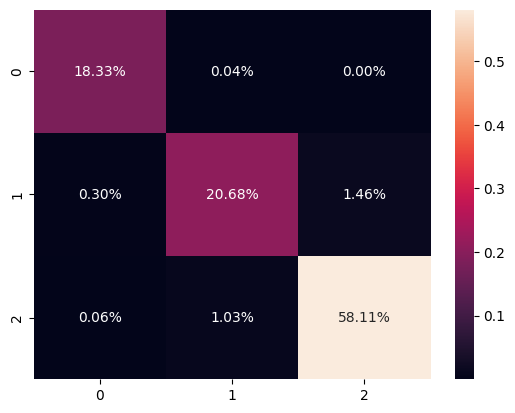

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy :  87.15%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     27146
           1       0.72      0.70      0.71     33154
           2       0.91      0.91      0.91     87461

    accuracy                           0.87    147761
   macro avg       0.85      0.86      0.85    147761
weighted avg       0.87      0.87      0.87    147761

             Confusion_matrix 


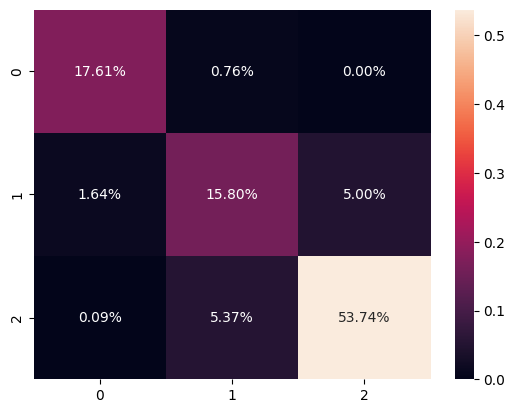

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  97.06%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27146
           1       0.95      0.92      0.93     33154
           2       0.98      0.98      0.98     87461

    accuracy                           0.97    147761
   macro avg       0.97      0.97      0.97    147761
weighted avg       0.97      0.97      0.97    147761

             Confusion_matrix 


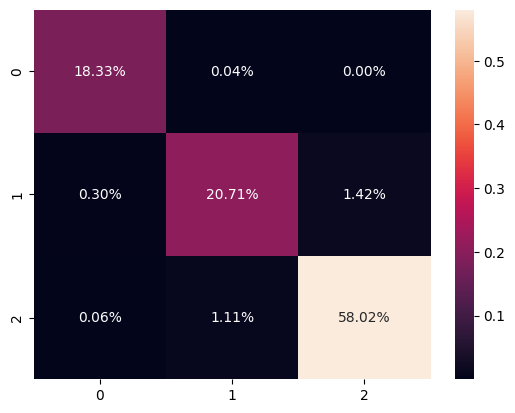

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> 
Test Accuracy :  92.77%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     27146
           1       0.88      0.79      0.83     33154
           2       0.95      0.97      0.96     87461

    accuracy                           0.93    147761
   macro avg       0.91      0.91      0.91    147761
weighted avg       0.93      0.93      0.93    147761

             Confusion_matrix 


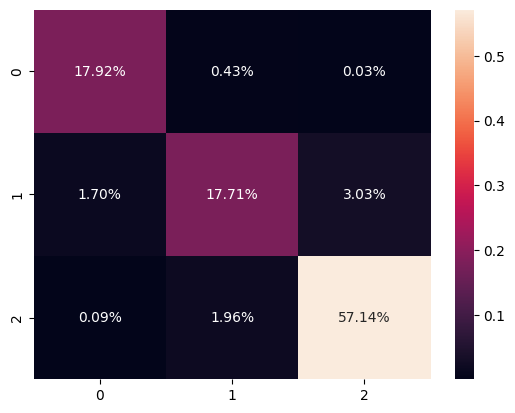

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  96.32%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27146
           1       0.94      0.89      0.92     33154
           2       0.96      0.98      0.97     87461

    accuracy                           0.96    147761
   macro avg       0.96      0.96      0.96    147761
weighted avg       0.96      0.96      0.96    147761

             Confusion_matrix 


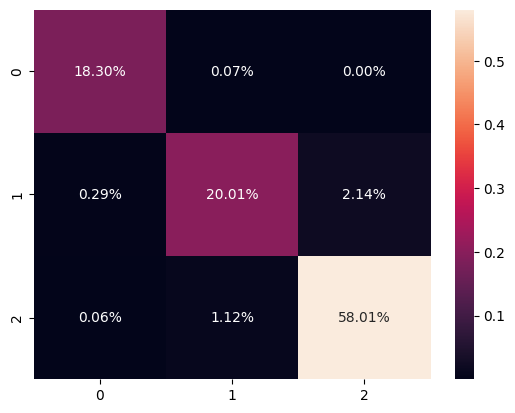

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  83.09%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27146
           1       0.83      0.31      0.45     33154
           2       0.80      0.98      0.88     87461

    accuracy                           0.83    147761
   macro avg       0.86      0.76      0.77    147761
weighted avg       0.83      0.83      0.80    147761

             Confusion_matrix 


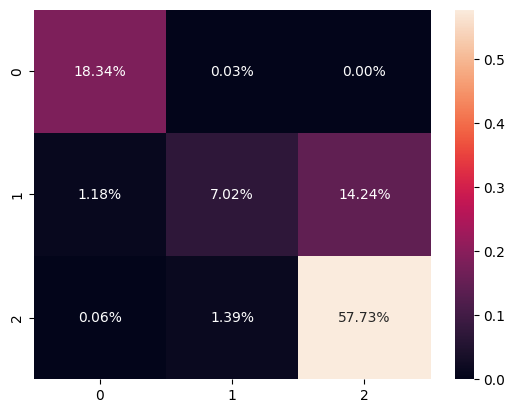

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.linear_model._ridge.RidgeClassifier'> 
Test Accuracy :  84.26%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     27146
           1       0.81      0.42      0.56     33154
           2       0.83      0.96      0.89     87461

    accuracy                           0.84    147761
   macro avg       0.85      0.78      0.80    147761
weighted avg       0.84      0.84      0.82    147761

             Confusion_matrix 


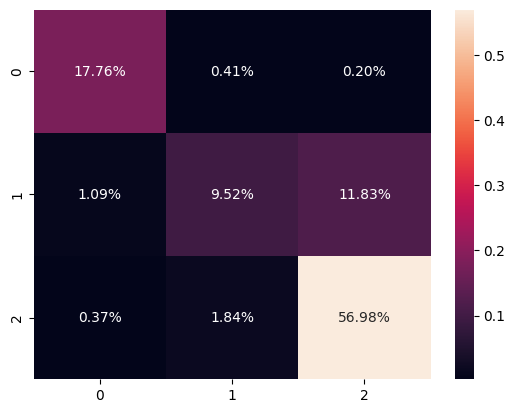

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  60.36%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     27146
           1       0.72      0.14      0.24     33154
           2       0.77      0.66      0.71     87461

    accuracy                           0.60    147761
   macro avg       0.63      0.60      0.51    147761
weighted avg       0.69      0.60      0.58    147761

             Confusion_matrix 


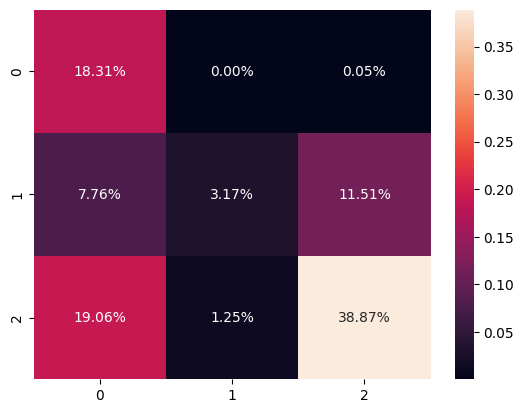

---------------------------------------------
---------------------------------------------
Model => <class 'sklearn.svm._classes.LinearSVC'> 
Test Accuracy :  87.98%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27146
           1       0.83      0.58      0.69     33154
           2       0.86      0.96      0.91     87461

    accuracy                           0.88    147761
   macro avg       0.89      0.85      0.86    147761
weighted avg       0.88      0.88      0.87    147761

             Confusion_matrix 


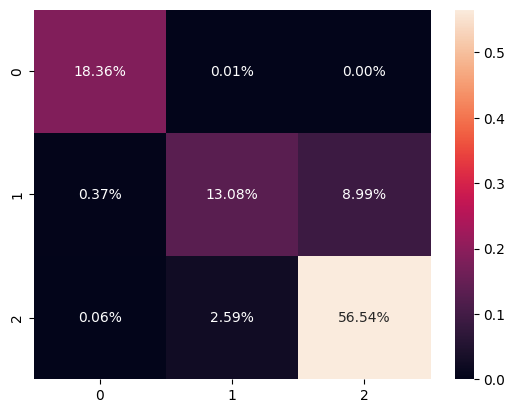

---------------------------------------------


In [ ]:
models = [RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, KNeighborsClassifier,
          SGDClassifier, RidgeClassifier, GaussianNB, LinearSVC]
accuracy_test=[]
for m in models:
    print('---------------------------------------------')
    print('Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('---------------------------------------------')

# Подведение итогов

In [ ]:
output = pd.DataFrame({"Model":['RandomForestClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier',
                                'KNeighborsClassifier', 'SGDClassifier', 'RidgeClassifier', 'GaussianNB', 'LinearSVC'],
                      "Accuracy":accuracy_test})

In [ ]:
output

,Model,Accuracy
0,RandomForestClassifier,0.971197
1,AdaBoostClassifier,0.871455
2,ExtraTreesClassifier,0.970588
3,GradientBoostingClassifier,0.927667
4,KNeighborsClassifier,0.963211
5,SGDClassifier,0.830923
6,RidgeClassifier,0.842584
7,GaussianNB,0.603563
8,LinearSVC,0.879759


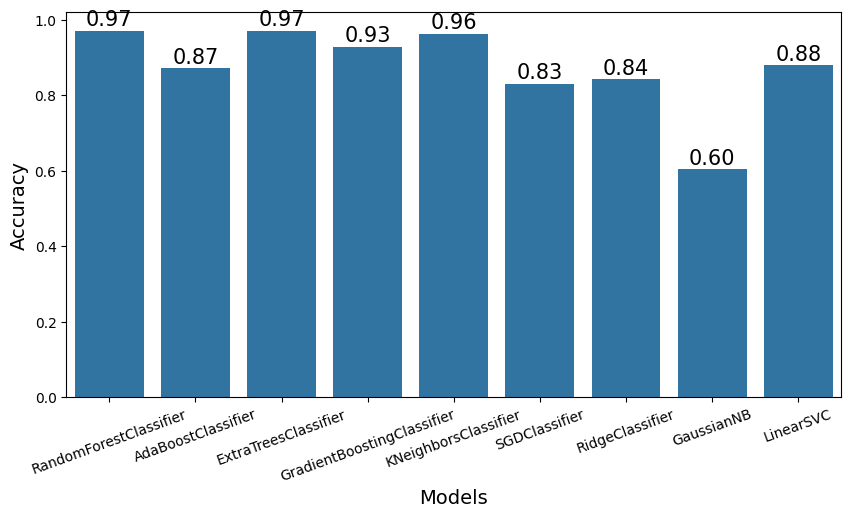

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()